In [16]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2

np.random.seed(42)
tf.random.set_seed(42)

In [17]:
folder_path = 'forms'  # Replace with the path to your folder

file_names = []


for file_name in os.listdir(folder_path):
    # Split the file name and extension
    file_name_without_ext = os.path.splitext(file_name)[0]
    file_names.append(file_name_without_ext)

file_names.sort()


In [18]:
del_list = [3, 2, 1]

sentence_list = []

lines = open("lines.txt", "r").readlines()

line_list = []
for line in lines:
    if line[0] == "#":
        continue
        
    inf = line.split()
    for ind in del_list:
        del inf[ind]
    inf[-1] = inf[-1].replace("|", " ")
    inf[0] = inf[0][:-3]
    line_list.append(inf)

file_infs = {}
labels_cord = []
labels_text = []
for file_name in file_names:
    files = [line for line in line_list if line[0] == file_name]
    x1, y1 = 4000, 4000
    x2, y2 = 0, 0
    text = ""
    for file in files:
        del file[0]
        x1_i, y1_i, w_i, h_i = int(file[0]), int(file[1]), int(file[2]), int(file[3])
        x2_i = x1_i + w_i
        y2_i = y1_i + h_i
        for string in file[4:]:
            text += string
            text += " "
        
        text+=" "
        
        
        if x1 > x1_i:
            x1 = x1_i
        if y1 > y1_i:
            y1 = y1_i
        if x2 < x2_i:
            x2 = x2_i
        if y2 < y2_i:
            y2 = y2_i
            
    w = x2-x1
    h = y2-y1
    labels_cord.append([x1, y1, w, h])
    labels_text.append(text)



In [19]:
folder_path = 'forms'

# List all the image files in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Sort the image files to maintain the order
image_files.sort()

# Initialize an empty list to store the image data
image_data = []
image_width = 600
image_height = 800

print(image_files[0])

forms\a01-000u.png


In [20]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image, k=1)
    return image


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [67]:
img1 = preprocess_image(image_files[0])

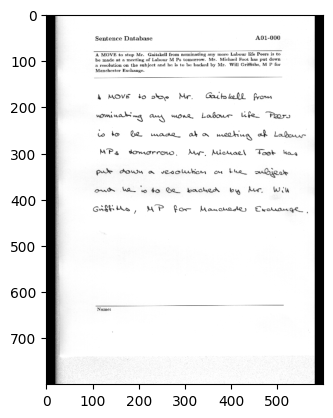

In [68]:
image_np = img1.numpy()

# Ensure the pixel values are in the range [0, 255]
image_np = (image_np * 255).astype(np.uint8)

# Display the image using Matplotlib
plt.imshow(image_np, cmap = "gray")


In [21]:
image_list = []
for file in image_files:
    img = preprocess_image(file)
    image_list.append(img)
    
image_tensor = tf.convert_to_tensor(image_list)
print(image_tensor.shape)

(1539, 800, 600, 1)


In [22]:
cord_tensor = tf.convert_to_tensor(labels_cord, dtype = tf.float64)
print(cord_tensor[:,0])

x = tf.multiply(cord_tensor[:, 0], (600/2479))
y = tf.multiply(cord_tensor[:, 1], (800/3542))
w = tf.multiply(cord_tensor[:, 2], (600/2479))
h = tf.multiply(cord_tensor[:, 3], (800/3542))


# Stack the tensors along the second axis (axis=1)
cord_tensor = tf.stack([x, y, w, h], axis=1)

print(cord_tensor.shape)

tf.Tensor([363. 375. 295. ... 320. 326. 344.], shape=(1539,), dtype=float64)
(1539, 4)


In [23]:
split_idx = int(0.9 * len(cord_tensor))
train_img = image_tensor[:split_idx]
train_cord = cord_tensor[:split_idx]
test_img = image_tensor[split_idx:]
test_cord = cord_tensor[split_idx:]
train_file_name = image_files[:split_idx]
test_file_name = image_files[split_idx:]

val_split_idx = int(0.5 * len(test_cord))
valid_img = test_img[:val_split_idx]
valid_cord = test_cord[:val_split_idx]
val_file_name = test_file_name[:val_split_idx]
test_img = test_img[val_split_idx:]
test_cord = test_cord[val_split_idx:]
test_file_name = test_file_name[val_split_idx:]

assert len(cord_tensor) == len(train_cord) + len(valid_cord) + len(test_cord)

print(f"Total training samples: {len(train_img)}")
print(f"Total validation samples: {len(valid_img)}")
print(f"Total test samples: {len(test_img)}")

Total training samples: 1385
Total validation samples: 77
Total test samples: 77


In [8]:
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(800, 600, 1)))
model.add(Conv2D(16, (5, 5), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(Conv2D(32, (5, 5), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4))  # Output layer with 4 units for the coordinates

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 796, 596, 6)       156       
                                                                 
 conv2d_1 (Conv2D)           (None, 792, 592, 16)      2416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 396, 296, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 392, 292, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 388, 288, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 194, 144, 32)     0         
 2D)                                                    

In [112]:
model.fit(train_img, train_cord, epochs=10, batch_size=32)

Epoch 1/10
44/44 [==============================] - 942s 21s/step - loss: 14249.9941
Epoch 2/10
44/44 [==============================] - 927s 21s/step - loss: 1053.1117
Epoch 3/10
44/44 [==============================] - 926s 21s/step - loss: 914.7951
Epoch 4/10
44/44 [==============================] - 936s 21s/step - loss: 831.1716
Epoch 5/10
44/44 [==============================] - 926s 21s/step - loss: 657.3209
Epoch 6/10
44/44 [==============================] - 927s 21s/step - loss: 663.5603
Epoch 7/10
44/44 [==============================] - 980s 22s/step - loss: 498.8481
Epoch 8/10
44/44 [==============================] - 1019s 23s/step - loss: 471.6519
Epoch 9/10
44/44 [==============================] - 1087s 25s/step - loss: 427.3273
Epoch 10/10
44/44 [==============================] - 1063s 24s/step - loss: 361.9073


In [114]:
model.evaluate(valid_img, valid_cord)


3/3 [==============================] - 9s 2s/step - loss: 409.6077


409.60772705078125

In [120]:
val_cord_pred = tf.cast(tf.round(model.predict(valid_img)), dtype = tf.int64)

3/3 [==============================] - 7s 2s/step


In [24]:
folder_path = "forms"
file_names = os.listdir(folder_path)
file_names.sort()


In [25]:
split_idx = int(0.9 * len(file_names))
train_file_name = file_names[:split_idx]
test_file_name = file_names[split_idx:]
val_split_idx = int(0.5 * len(test_file_name))
val_file_name = test_file_name[:val_split_idx]
test_file_name = test_file_name[val_split_idx:]

In [31]:

dest_path = "train_crop"
for i in range(len(train_file_name)):
    img = np.array(train_img[i].numpy())
    img = np.array(np.multiply(img, 255), dtype = np.uint8)
    cord = tf.cast(tf.round(train_cord[i]), dtype = tf.int64)
    x, y, w, h = cord[0], cord[1], cord[2], cord[3]
    img = img[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dest_path, train_file_name[i]), img)

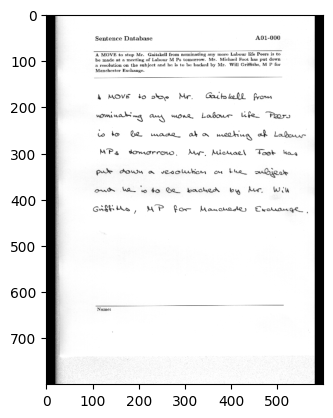

In [28]:
img = np.array(train_img[0].numpy())
img = np.array(np.multiply(img, 255), dtype = np.uint8)
plt.imshow(img, cmap="gray")

In [160]:

dest_path = "valid_crop"
for i in range(len(val_file_name)):
    img = np.array(valid_img[i].numpy())
    img = np.array(np.multiply(img, 255), dtype = np.uint8)
    cord = val_cord_pred[i]
    x, y, w, h = cord[0], cord[1], cord[2], cord[3]
    img = img[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dest_path, val_file_name[i]), img)

In [115]:
model.evaluate(test_img, test_cord)

3/3 [==============================] - 8s 2s/step - loss: 468.0846


468.0845642089844

In [150]:
test_cord_pred = tf.cast(tf.round(model.predict(test_img)), dtype = tf.int64)

3/3 [==============================] - 8s 2s/step


In [153]:
test_img[0]

<tf.Tensor: shape=(800, 600, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

In [11]:

dest_path = "test_crop"
for i in range(len(test_file_name)):
    img = np.array(test_img[i].numpy())
    img = np.array(np.multiply(img, 255), dtype = np.uint8)
    cord = test_cord_pred[i]
    x, y, w, h = cord[0], cord[1], cord[2], cord[3]
    img = img[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dest_path, test_file_name[i]), img)

NameError: name 'test_cord_pred' is not defined

In [162]:
print(len(test_file_name))

77
